## Gradient Boosting Example

In [1]:
import os
import imageio
import numpy as np
from glob import glob
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from airxd.mask import MASK
from airxd.model import ARIXD
from airxd.dataset import Dataset, parse_imctrl
from sklearn.metrics import confusion_matrix as CM

### Create/load data Nickel dataset

In [2]:
# 1. If the masks doesn't exist, we will build the masks with AutoSpotMask.
# 2. The masking process will several minutes depending on the CPU power.
# 3. Save the masks to ../data/Nickel/masks directory, so no further recomputation.

# For convention, the masks/labels folder will always exist inside the dataset directory.
# Hence, we created the masks folder in this fashion: ../data/Nickel/' + 'masks'

Nickel = '../data/Nickel/'
if not os.path.isdir(Nickel+'masks'):
    controls = parse_imctrl(Nickel+'Si_ch3_d700-00000.imctrl')
    mask = MASK(controls=controls, shape=(2880,2880))
    os.mkdir(Nickel+'masks')
    paths = glob(Nickel+'*.tif')
    for path in paths:
        image_name = path.split('/')[-1][:-4]
        image = imageio.volread(path)
        result = mask.AutoSpotMask(image, esdmul=7.0)
        imageio.imwrite(Nickel+f'masks/{image_name}.tif', result)

### In a beamline application, user can specify the directory where the collected XRD images are located. In this case, the images are located in "../data/Nickel/" directory.

In [3]:
directories = [Nickel]

# Instantiate the Dataset class
dataset = Dataset(n=len(directories))

# Call the get_data() method. 
# The imctrl file is search by this method and converted into 2-theta and azimuth maps.
dataset.get_data(directories, label_ext='.tif')

### Visualize a masking result

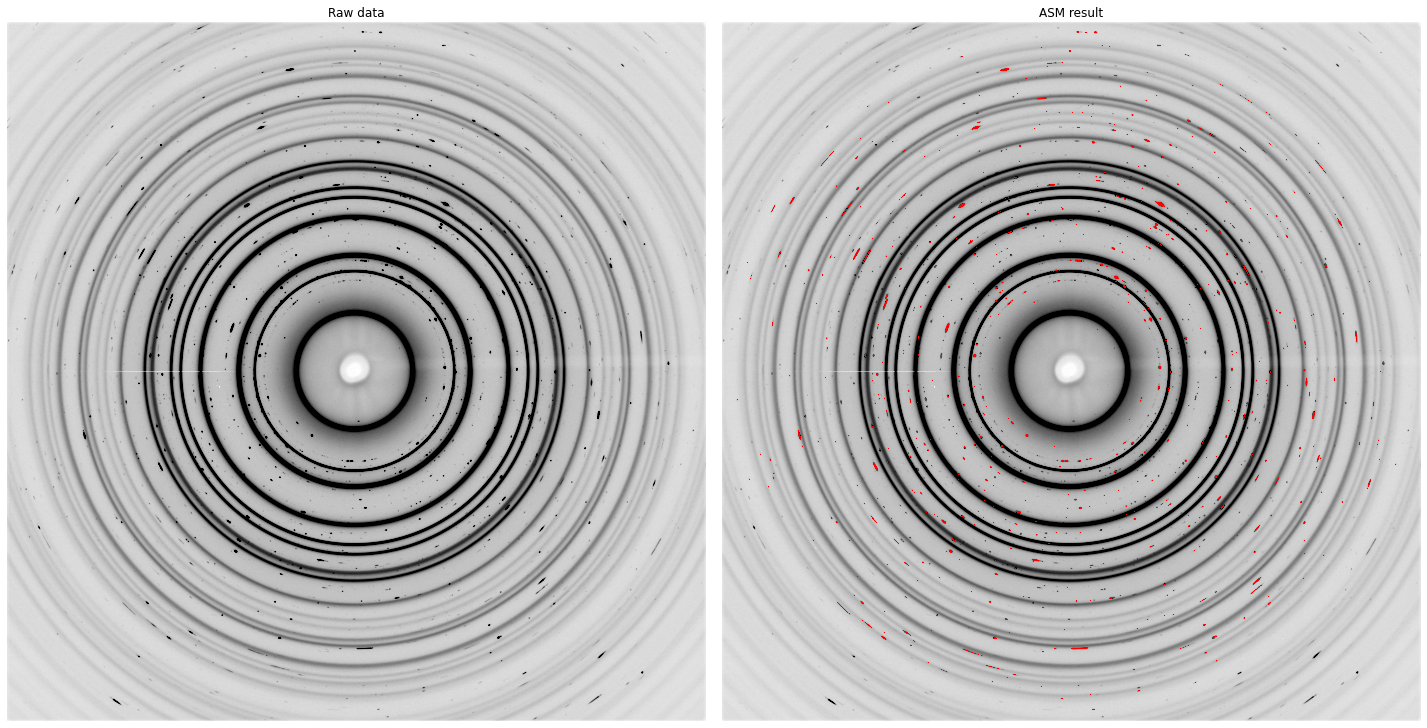

In [4]:
num = np.random.randint(0, len(dataset.images[0]))
image, label = dataset.images[0][num], dataset.labels[0][num]
lbl = np.array(label, dtype=float)
lbl = np.ma.masked_where(lbl==0., lbl)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(image, vmin=0, vmax=15000, cmap='binary', origin='lower')
plt.title('Raw data')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(image, vmin=0, vmax=15000, cmap='binary', origin='lower')
plt.imshow(lbl, cmap=cm.autumn, origin='lower', interpolation='nearest')
plt.title('ASM result')
plt.axis('off')
plt.tight_layout()
plt.show()

### Gradient Boosting Training

In [5]:
device = 'cpu'
tree_method = 'hist' if device == 'cpu' else 'gpu_hist'
predictor = 'cpu_predictor' if device == 'cpu' else 'gpu_predictor'
max_depth = 10
no_cpus = -1 if device == 'cpu' else 1

algorithm = 'gradient_boosting'

parameters = {'n_estimators': 100,
              'eta': 0.3,
              'tree_method': tree_method,
              'gamma': 0.,
              'max_bin': 10000,
              'predictor': predictor,
              'max_depth': max_depth,
              'reg_lambda': 1.,
              'eval_metric': 'rmsle',
              'n_jobs': no_cpus}

features = {'intensity': True,
            '2-theta': True,
            'azimuth': False,
            'locations': False}

include_data argument tells the ARIXD to use image #1, #3, and #8 of the Nickel dataset (0). {0: [1, 3, 8]} can be replaced by 'random' to randomly select images for all dataset. {0: []} indicates no image from 0th dataset for training.

In [6]:
model = ARIXD(algorithm, parameters, features)
model.train(dataset, include_data={0: [1, 3, 8]})

0 :  [1, 3, 8]


### Prediction

In [7]:
mattol = np.zeros((4)) 
for i, (image, label) in enumerate(zip(dataset.images[0], dataset.labels[0])):
    label_pred = model.predict(image, dataset.TAs[0]) # TAs[0]) is to get the 2-theta / azimuth map
    matrix = CM(label.ravel(), label_pred.ravel())
    if i not in [1, 3, 8]: # Avoid taking training images into overall TP and TN rates.
        mattol += matrix.ravel()
    tn, fp, fn, tp = matrix.ravel()
    tn_rate = tn/(fp+tn)*100
    tp_rate = tp/(fn+tp)*100
    print(f"Image {i}")
    print(f'True Negative   : {tn}')
    print(f'False Positive  : {fp}')
    print(f'False Negative  : {fn}')
    print(f'True Positive   : {tp}')
    print(f'True TN rate    : {round(tn_rate,1)} %')
    print(f'True TP rate    : {round(tp_rate,1)} %')
    print('\n')
tn_rate = mattol[0]/(mattol[1]+mattol[0])*100
tp_rate = mattol[3]/(mattol[2]+mattol[3])*100
print(f'Overall true negative rate    : {round(tn_rate,1)} %')
print(f'Overall true positive rate    : {round(tp_rate,1)} %')

Image 0
True Negative   : 8262918
False Positive  : 178
False Negative  : 789
True Positive   : 30515
True TN rate    : 100.0 %
True TP rate    : 97.5 %


Image 1
True Negative   : 8260749
False Positive  : 96
False Negative  : 225
True Positive   : 33330
True TN rate    : 100.0 %
True TP rate    : 99.3 %


Image 2
True Negative   : 8265269
False Positive  : 213
False Negative  : 501
True Positive   : 28417
True TN rate    : 100.0 %
True TP rate    : 98.3 %


Image 3
True Negative   : 8266533
False Positive  : 24
False Negative  : 286
True Positive   : 27557
True TN rate    : 100.0 %
True TP rate    : 99.0 %


Image 4
True Negative   : 8267839
False Positive  : 164
False Negative  : 729
True Positive   : 25668
True TN rate    : 100.0 %
True TP rate    : 97.2 %


Image 5
True Negative   : 8274050
False Positive  : 1210
False Negative  : 285
True Positive   : 18855
True TN rate    : 100.0 %
True TP rate    : 98.5 %


Image 6
True Negative   : 8281831
False Positive  : 1009
False Negative

## Visualize prediction

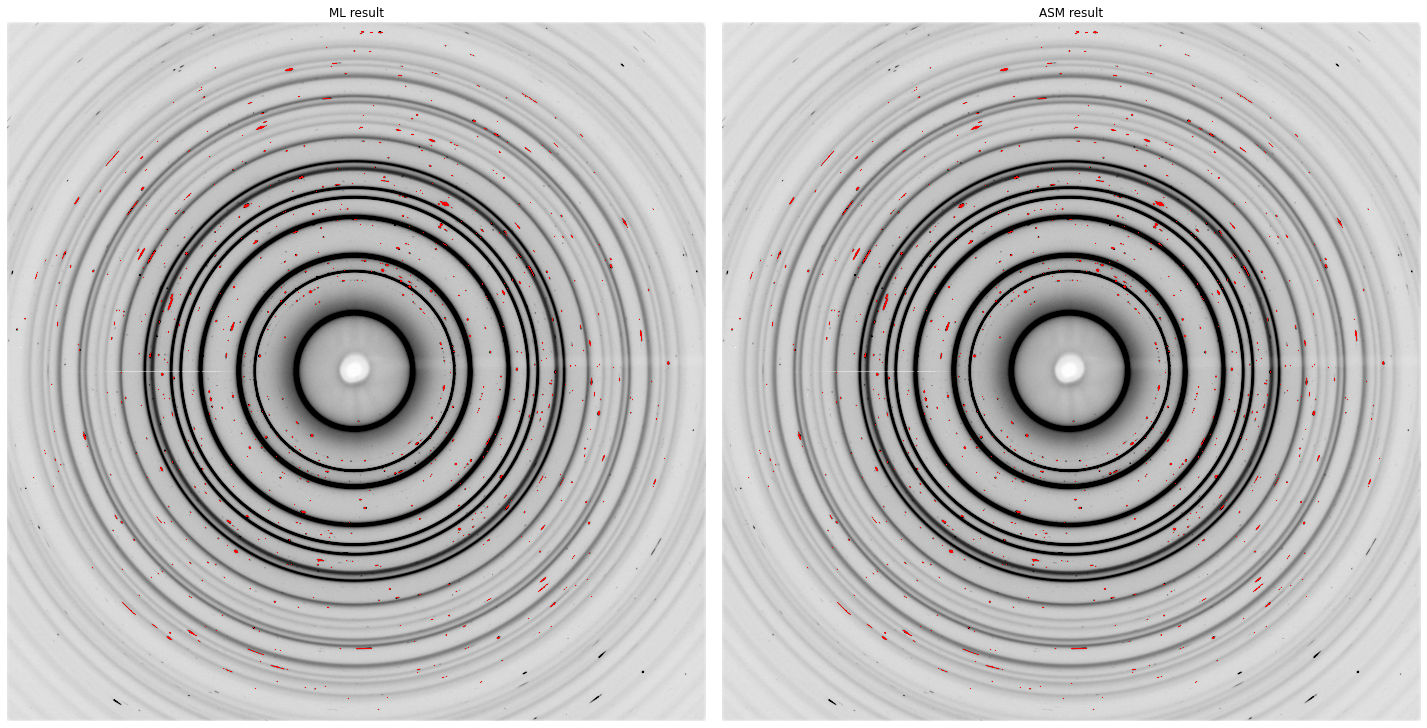

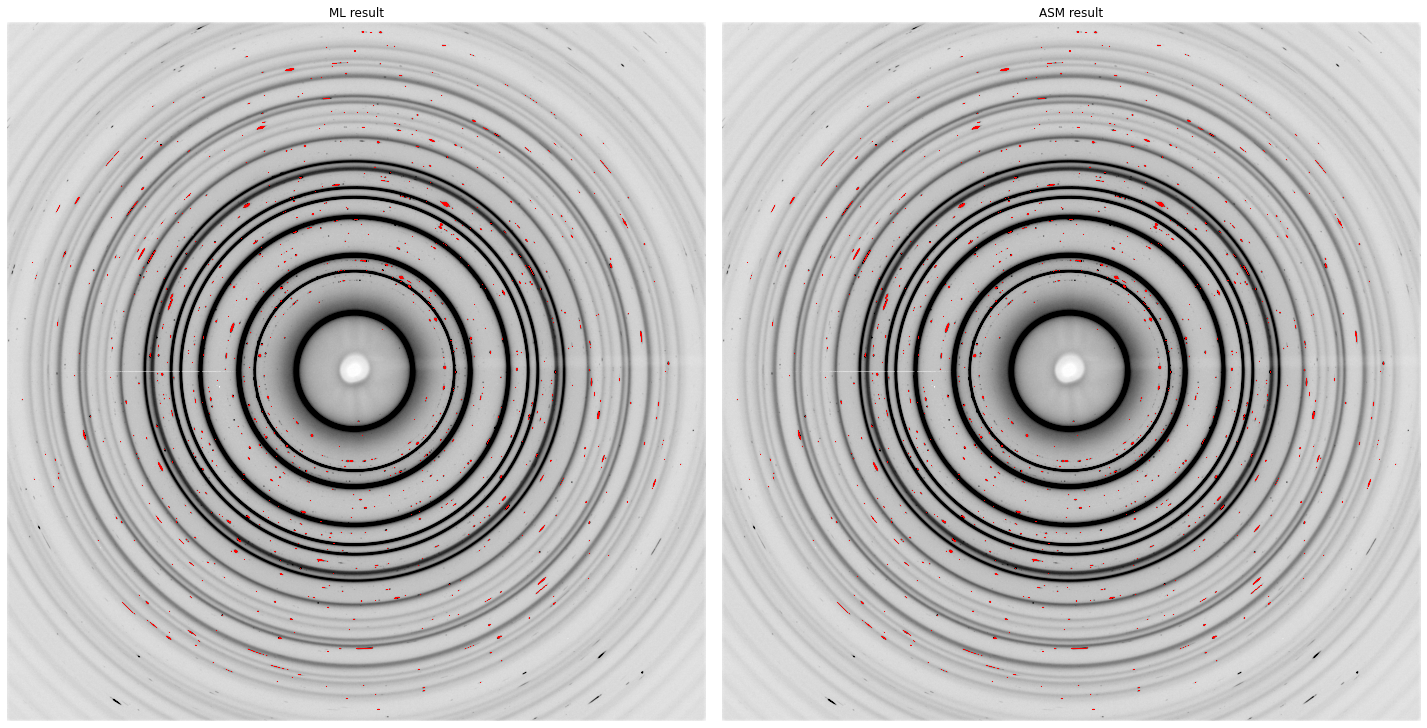

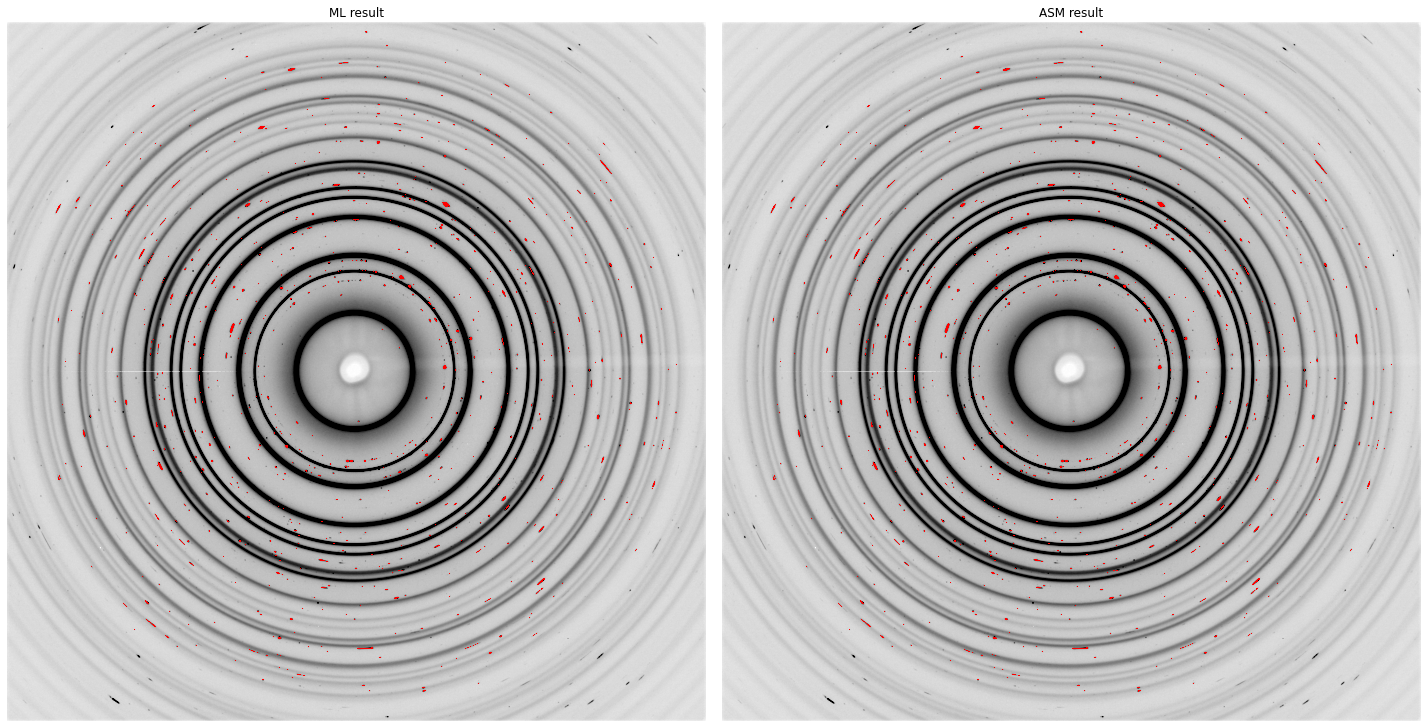

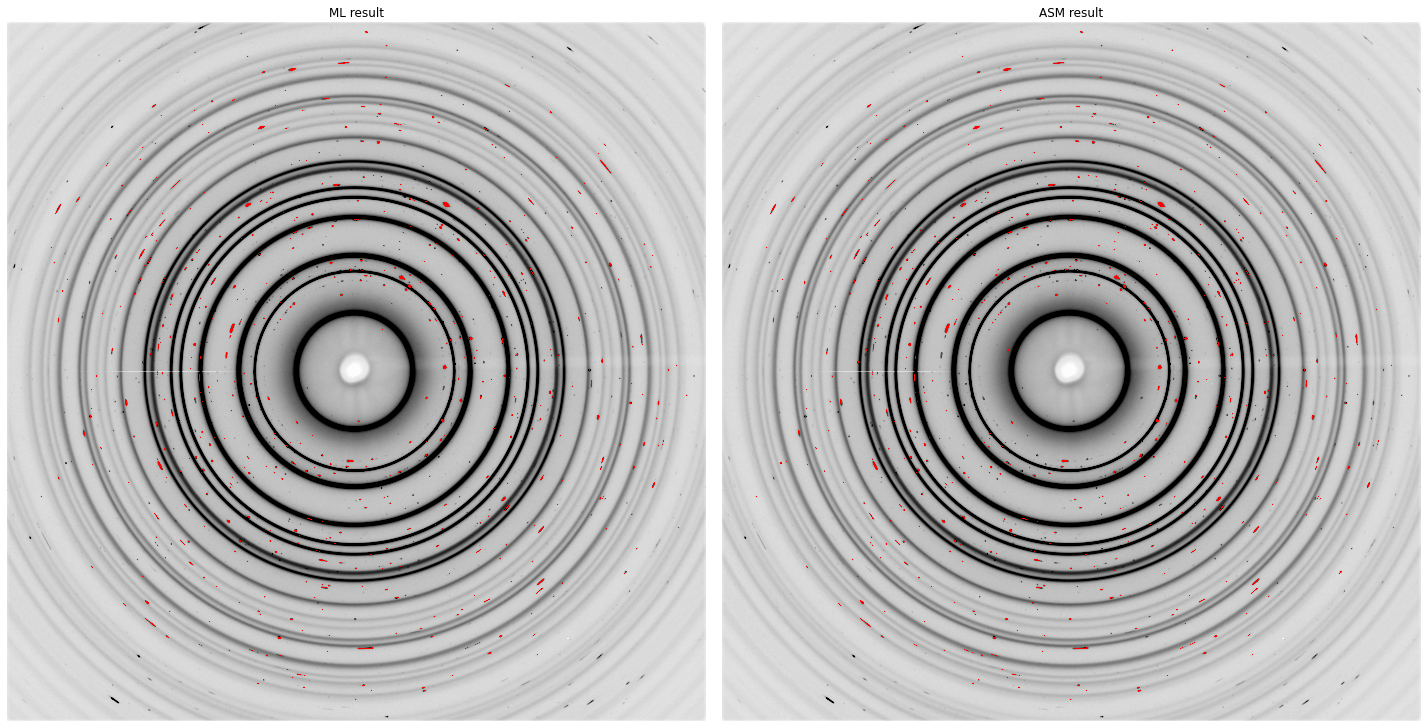

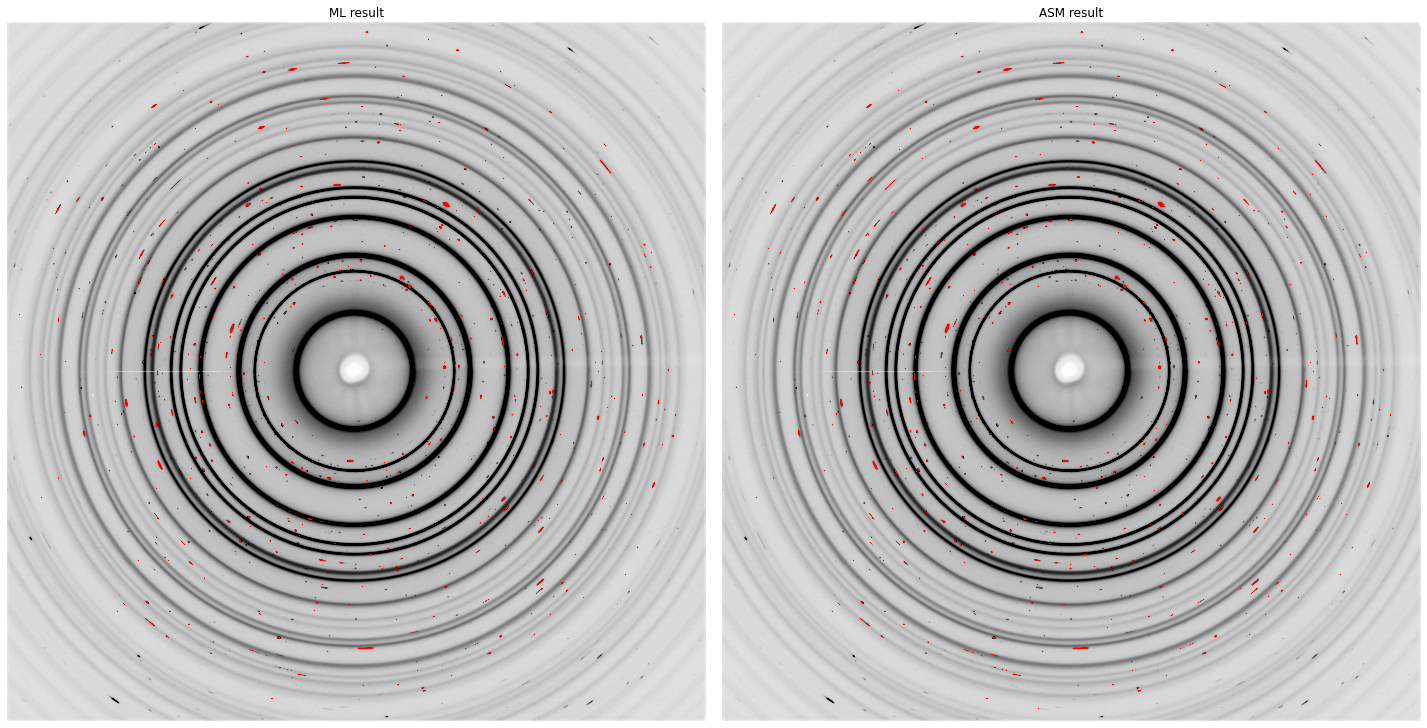

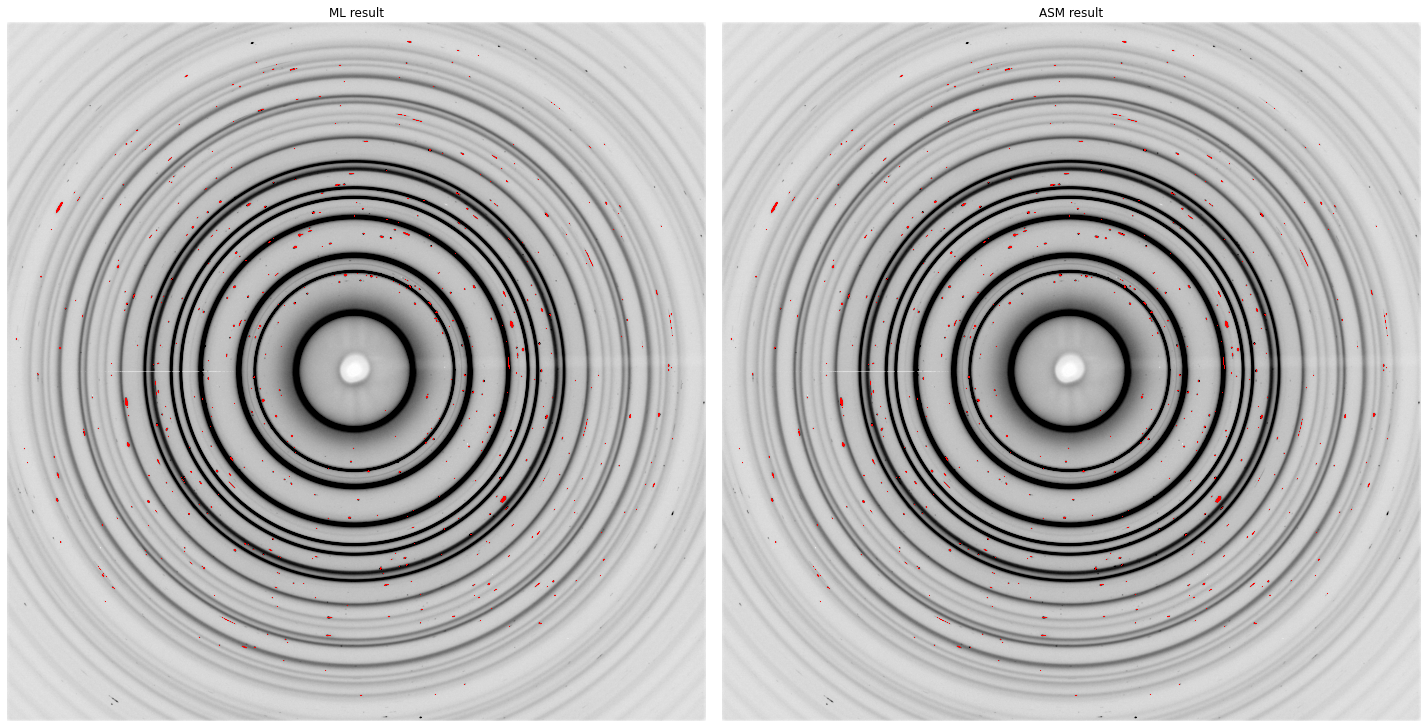

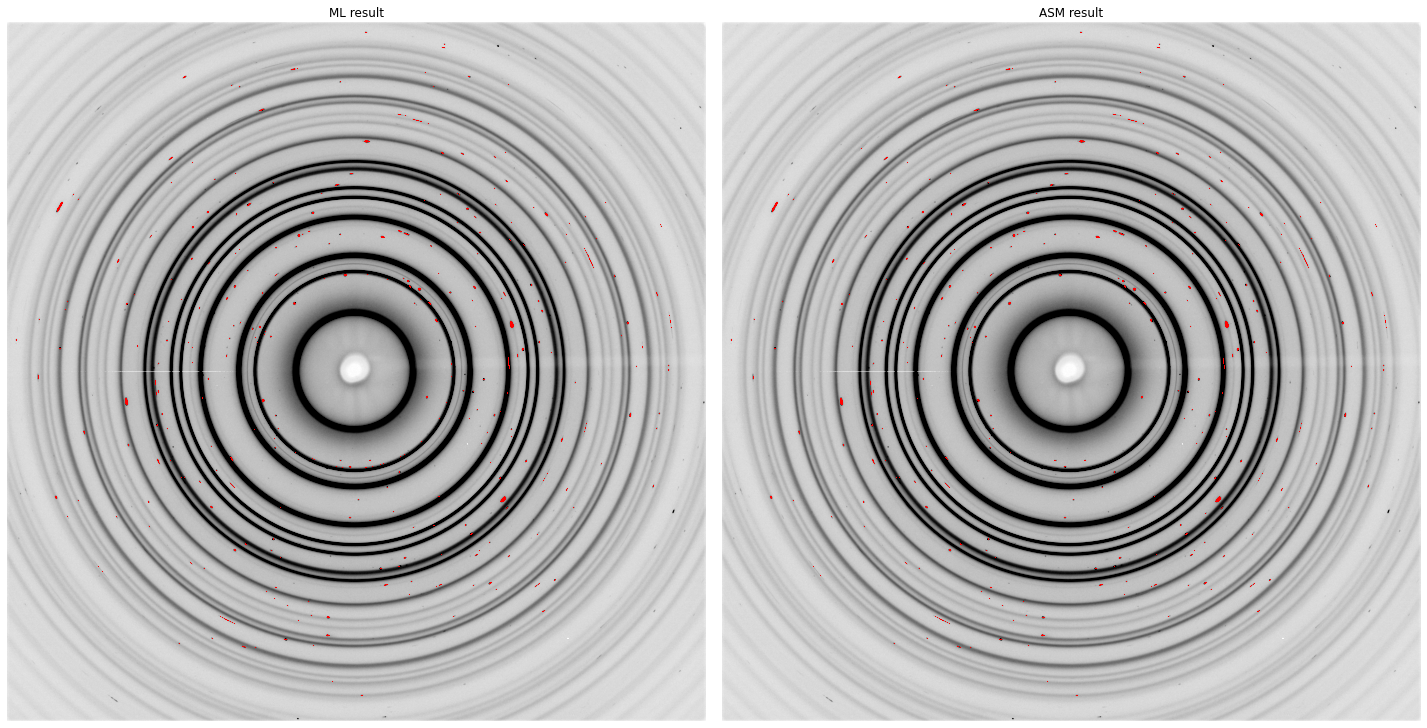

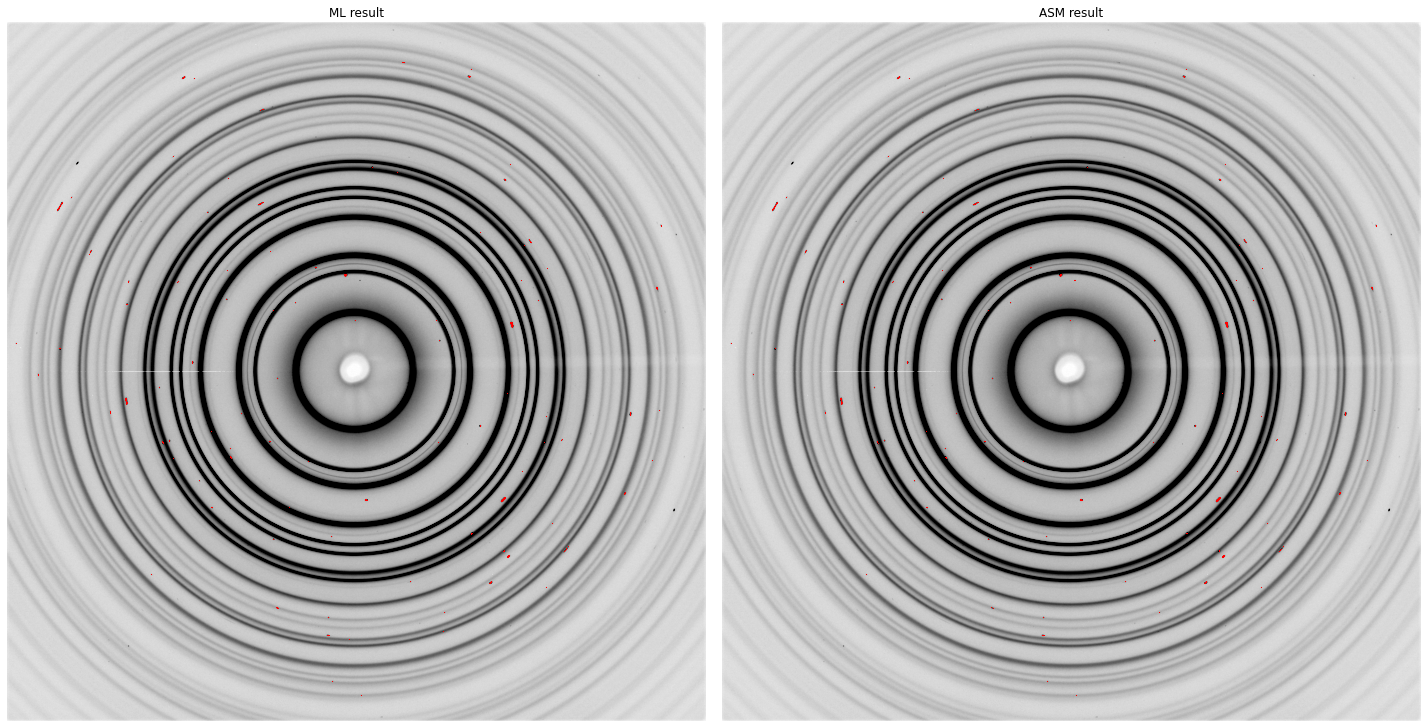

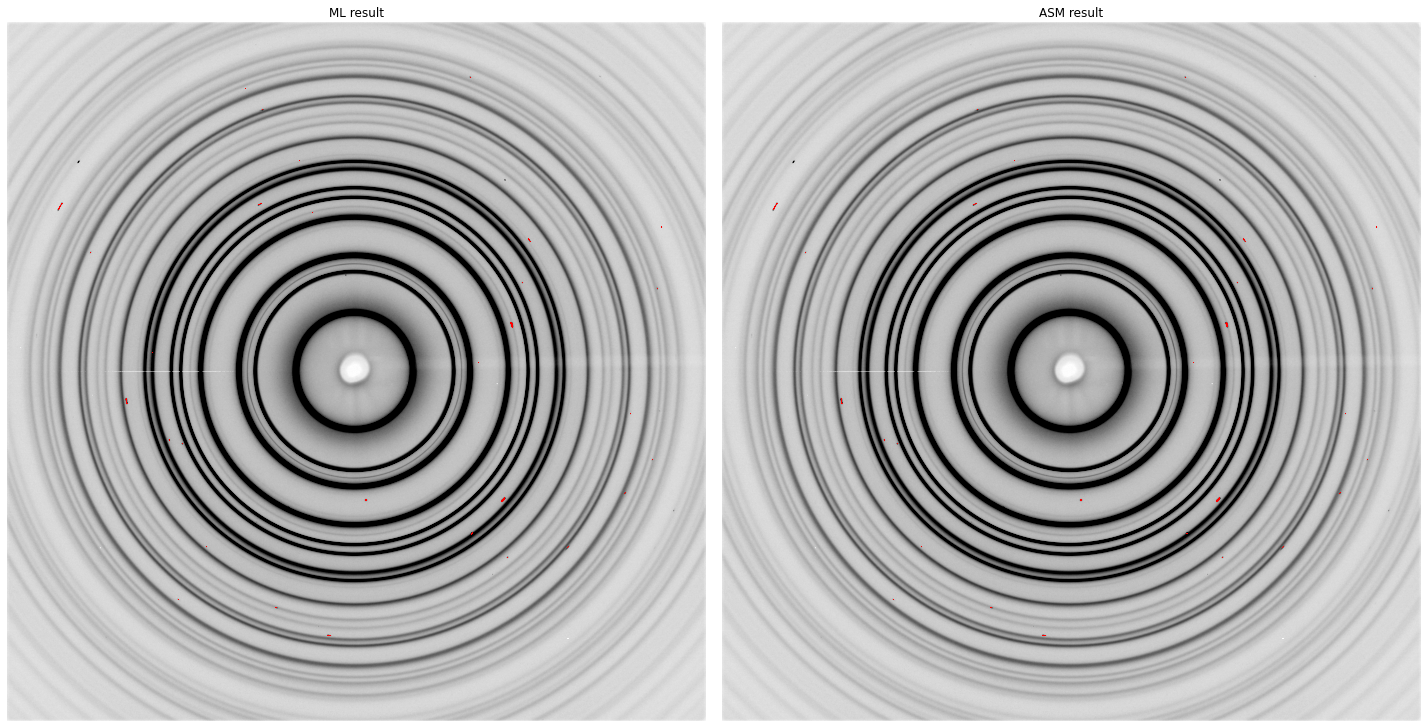

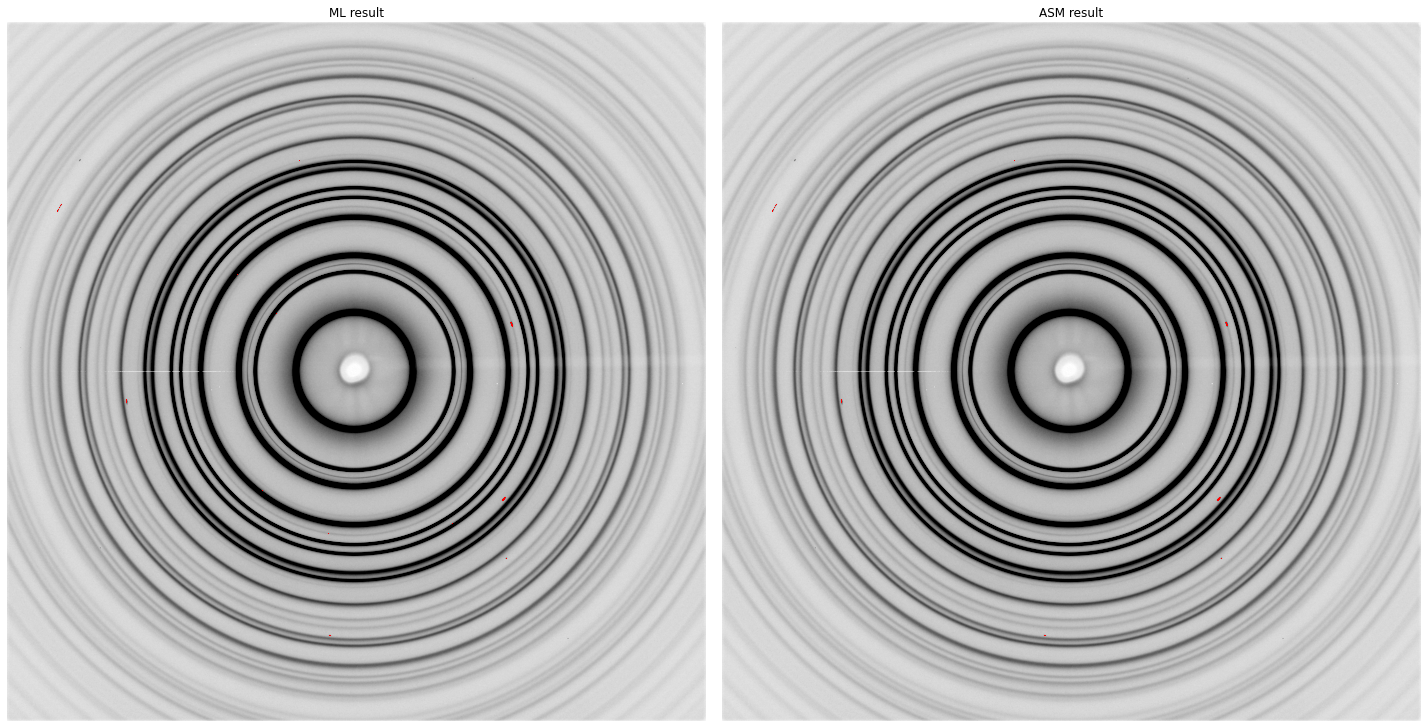

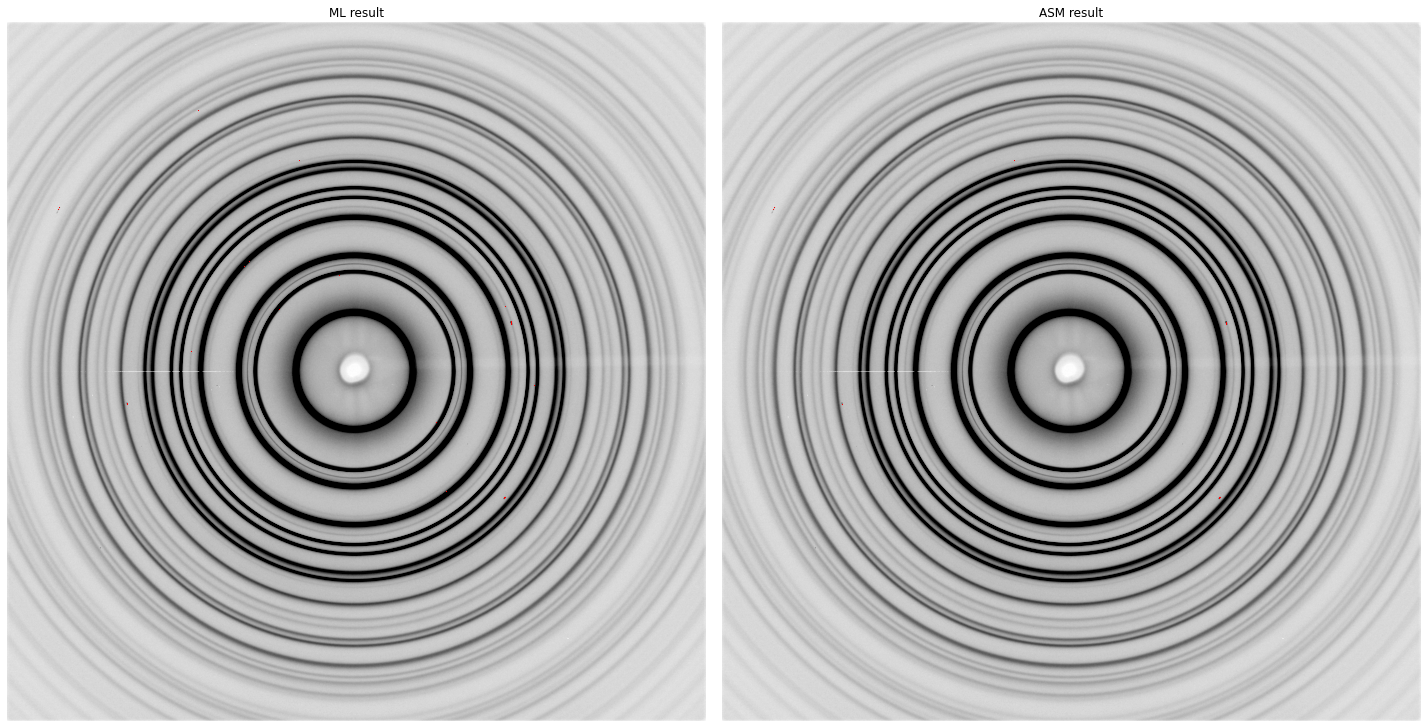

In [8]:
for i, (image, label) in enumerate(zip(dataset.images[0], dataset.labels[0])):
    label_pred = model.predict(image, dataset.TAs[0])
    lbl0 = np.array(label_pred, dtype=float)
    lbl0 = np.ma.masked_where(lbl0==0., lbl0)
    lbl1 = np.array(label, dtype=float)
    lbl1 = np.ma.masked_where(lbl1==0., lbl1)
    
    plt.figure(figsize=(20,10))
    # ML result
    plt.subplot(1,2,1)
    plt.imshow(image, vmin=0, vmax=15000, cmap='binary', origin='lower')
    plt.imshow(lbl0, cmap=cm.autumn, origin='lower', interpolation='nearest')
    plt.title('ML result')
    plt.axis('off')
    # ASM search
    plt.subplot(1,2,2)
    plt.imshow(image, vmin=0, vmax=15000, cmap='binary', origin='lower')
    plt.imshow(lbl1, cmap=cm.autumn, origin='lower', interpolation='nearest')
    plt.title('ASM result')
    plt.axis('off')
    plt.tight_layout()
    plt.show()